In [1]:
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
import netwulf as nw
from scipy.optimize import minimize

In [2]:
G = nx.Graph()

In [3]:
#given "points" with labels a and b we can assign probability of an edge between them
def basic_func(a,b):
    if a == b:
        return .8
    else:
        return .2

In [4]:
G.add_node(1)
G.add_node(1)

In [5]:
G.graph

{}

In [6]:
G.add_node(1, label='1', color='red')
G.add_node(2, label='0', color='blue')
G.add_edge(1, 2)

In [7]:
G.nodes.data()

NodeDataView({1: {'label': '1', 'color': 'red'}, 2: {'label': '0', 'color': 'blue'}})

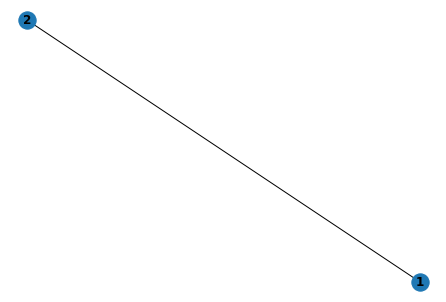

In [8]:
nx.draw(G, with_labels=True, font_weight='bold')

In [9]:
node_colors = []

In [10]:
def create_graph(num_nodes, labels, func):
    G = nx.Graph()
    for i in range(num_nodes):
        G.add_node(i, group=labels[i])
        for j in range(i):
            if func(labels[i], labels[j]) != func(labels[j],labels[i]):
                print("WARNING, asymetric function")
            if np.random.rand() < func(labels[i], labels[j]):
                G.add_edge(i, j)
    return G

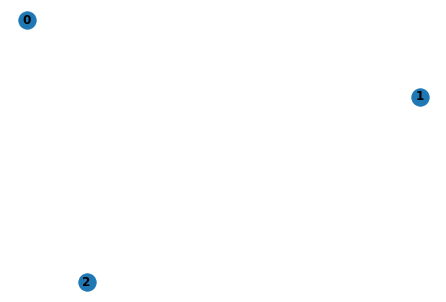

In [12]:
n = 3
G = create_graph(n, np.random.randint(2,size=100), basic_func)
nx.draw(G, with_labels=True, font_weight='bold')

In [13]:
# Or detect communities and encode them in 'group' attribute
# import community
# bb = community.best_partition(G)
# nx.set_node_attributes(G, bb, 'group')

# Set node 'size' attributes
for n, data in G.nodes(data=True):
    data['size'] = 1

# Set link 'weight' attributes
for n1, n2, data in G.edges(data=True):
    data['weight'] = 1

nw.visualize(G)

(None, None)

In [14]:
for node in G:
    print(G[node])

{}
{}
{}


In [15]:
def bound(num, upper=1, lower = 0):
    return min(max(num, lower), 1)

def create_func_2param(params):
    return lambda x,y: bound(sum([params[i]*x**i for i in range(len(params))])*sum([params[i]*y**i for i in range(len(params))]))

def create_func_1param(params):
    return lambda x: bound(sum([params[i]*x**i for i in range(len(params))]))

#def calculcute_loss(graph, labels, func):
#    numpy_vec = np.
#    func([labels]) @ func([labels]).T * nx.to_numpy_array(graph)

In [16]:
func = create_func_1param([.1,.2])
func = np.vectorize(func)

In [17]:
labels = [.4,.8,.9]
func([labels])
func([labels]).T @ func([labels])


array([[0.0324, 0.0468, 0.0504],
       [0.0468, 0.0676, 0.0728],
       [0.0504, 0.0728, 0.0784]])

In [18]:
create_func_1param(.1)

<function __main__.create_func_1param.<locals>.<lambda>(x)>

In [19]:
create_func_2param([.5,.2])(.4, .2)

0.31320000000000003

In [20]:
A = nx.to_numpy_array(G)
B = nx.to_numpy_array(nx.complement(G))

In [21]:
def log_likelihood(g, labels, params):
    n = len(labels)
    vec = np.zeros(n).reshape(-1, 1)
    labels = np.array(labels).reshape(-1,1)
    for i in range(len(params)):
        vec += labels**i*params[i]
    transition_predictions = vec @ vec.T
    transition_predictions = np.clip(transition_predictions, .0001, .999)
    prod = transition_predictions*nx.to_numpy_array(G) + (1-transition_predictions)*nx.to_numpy_array(nx.complement(G))
    log_matrix = np.log(prod + np.identity(n))
    return np.sum(log_matrix)/(n*(n-1))

In [22]:
def probability_matrix(labels, params):
    n = len(labels)
    vec = np.zeros(n).reshape(-1, 1)
    labels = np.array(labels).reshape(-1,1)
    for i in range(len(params)):
        vec += labels**i*params[i]
    transition_predictions = vec @ vec.T
    transition_predictions = np.clip(transition_predictions, .0001, .999)
    return transition_predictions

In [23]:
np.zeros(len(labels)).reshape(-1, 1)

array([[0.],
       [0.],
       [0.]])

In [24]:
labels = np.array(labels).reshape(-1,1)

In [25]:
labels**0

array([[1.],
       [1.],
       [1.]])

In [26]:
params = [.1,.2]
vec = np.zeros(len(labels)).reshape(-1, 1)
labels = np.array(labels).reshape(-1,1)
for i in range(len(params)):
    vec += labels**i*params[i]
vec

array([[0.18],
       [0.26],
       [0.28]])

In [27]:
transition_predictions = vec @ vec.T
transition_predictions = np.clip(transition_predictions, .0001, .999)
transition_predictions

array([[0.0324, 0.0468, 0.0504],
       [0.0468, 0.0676, 0.0728],
       [0.0504, 0.0728, 0.0784]])

In [28]:
G = create_graph(3, np.random.randint(2,size=3), basic_func)

In [29]:
prod = transition_predictions*nx.to_numpy_array(G) + (1-transition_predictions)*nx.to_numpy_array(nx.complement(G))

In [30]:
np.log(prod + np.identity(3))

array([[ 0.        , -0.04793053, -2.9877641 ],
       [-0.04793053,  0.        , -2.62003932],
       [-2.9877641 , -2.62003932,  0.        ]])

In [31]:
nx.to_numpy_array(G)

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 1., 0.]])

In [32]:
log_likelihood(G, labels, params)

-1.8852446538139536

In [33]:
len(G.nodes)

3

In [34]:
log_likelihood(G, labels, [.3,.9])

-0.4768542816557652

In [35]:
def find_opt_params(g, num_params = 2):
    labels = len(g.nodes)
    func = lambda x: -log_likelihood(g, x[:-num_params], x[-num_params:])
    bounds = [(0,1) for i in range(labels)] + [(None, None) for i in range(num_params)]
    res = minimize(func, list(np.random.rand(labels + num_params)),
                   bounds=bounds, method='SLSQP', options={'maxiter': 30})
    return res.x

In [39]:
log_likelihood(G, np.random.rand(3), [.3,.2])

-1.4601240716064179

In [40]:
l = find_opt_params(G)

In [41]:
np.round(probability_matrix(l[:-2], l[-2:]))

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 1., 1.]])

In [42]:
G = create_graph(100, np.random.randint(2,size=100), basic_func)

In [43]:
l = find_opt_params(G)
np.round(probability_matrix(l[:-2], l[-2:]))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [44]:
np.round(probability_matrix(l[:-2], l[-2:]))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [45]:
l

array([ 0.88262786,  0.52997277,  0.95167651,  0.89550474,  0.57001142,
        0.10928946,  0.10899345,  0.72639   ,  0.52222869,  0.65017704,
        0.4231421 ,  0.26459928,  0.12920215,  0.31417804,  0.88250929,
        0.28343702,  0.11441269,  0.46985944,  0.16686498,  0.91727621,
        0.78205724,  0.72019675,  0.2776473 ,  0.56154448,  0.84383129,
        0.34319528,  0.93661131,  0.75887327,  0.27083034,  0.87982006,
        0.17998528,  0.30272024,  0.37183007,  0.1657936 ,  0.59538717,
        0.69161439,  0.10758585,  0.92351118,  0.77153983,  0.92441106,
        0.25263782,  0.3947624 ,  0.37746994,  0.84945348,  0.41251209,
        0.0650895 ,  0.10875172,  0.93414418,  0.75607761,  0.39104827,
        0.47257315,  0.04632102,  0.68601525,  0.65564285,  0.4726159 ,
        0.61801266,  0.49842439,  0.84217943,  0.32979453,  0.10055305,
        0.74978293,  0.97947285,  0.07682764,  0.2638857 ,  0.71883298,
        0.30104385,  0.97078278,  0.07905982,  0.88426992,  0.49

# looking at my results compared to true graph values

In [48]:
true_labels = np.random.randint(2,size=200)

n = 200
G = create_graph(n, true_labels, basic_func)
#nx.draw(G, with_labels=True, font_weight='bold')

In [49]:
G_mat = nx.to_numpy_array(create_graph(n, true_labels, basic_func))/1000

for i in range(999):
    #print(i)
    G_mat += nx.to_numpy_array(create_graph(n, true_labels, basic_func))/1000

G_mat

array([[0.   , 0.212, 0.213, ..., 0.789, 0.802, 0.197],
       [0.212, 0.   , 0.805, ..., 0.203, 0.192, 0.816],
       [0.213, 0.805, 0.   , ..., 0.205, 0.238, 0.82 ],
       ...,
       [0.789, 0.203, 0.205, ..., 0.   , 0.79 , 0.186],
       [0.802, 0.192, 0.238, ..., 0.79 , 0.   , 0.193],
       [0.197, 0.816, 0.82 , ..., 0.186, 0.193, 0.   ]])

In [50]:
def log_likelihood_optimized(G, G_c, labels, params):
    n = len(labels)
    vec = np.zeros(n).reshape(-1, 1)
    labels = np.array(labels).reshape(-1,1)
    for i in range(len(params)):
        vec += labels**i*params[i]
    transition_predictions = vec @ vec.T
    transition_predictions = np.clip(transition_predictions, .0001, .999)
    prod = transition_predictions*G + (1-transition_predictions)*G_c
    log_matrix = np.log(prod + np.identity(n))
    return np.sum(log_matrix)/(n*(n-1))

In [51]:
def find_opt_params_optimized(g, num_params = 2):
    labels = len(g.nodes)
    G_c = nx.to_numpy_array(nx.complement(g))
    G = nx.to_numpy_array(g)
    func = lambda x: -log_likelihood_optimized(G,G_c, x[:-num_params], x[-num_params:])
    bounds = [(0,1) for i in range(labels)] + [(None, None) for i in range(num_params)]
    res = minimize(func, list(np.random.rand(labels + num_params)),
                   bounds=bounds, method='SLSQP', options={'maxiter': 100, 'disp': True})
    return res.x
def find_opt_params_optimized(g, num_params = 2):
    labels = len(g.nodes)
    G_c = nx.to_numpy_array(nx.complement(g))
    G = nx.to_numpy_array(g)
    func = lambda x: -log_likelihood_optimized(G,G_c, x[:-num_params], x[-num_params:])
    bounds = [(0,1) for i in range(labels)] + [(None, None) for i in range(num_params)]
    res = minimize(func, list(np.random.rand(labels + num_params)),
                    method='BFGS', options={'maxiter': 100, 'disp': True})
    return res.x

In [57]:
l = find_opt_params_optimized(G, num_params=2)
np.round(probability_matrix(l[:-2], l[-2:]))

         Current function value: 0.686925
         Iterations: 100
         Function evaluations: 24360
         Gradient evaluations: 120


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 0., 1.],
       [0., 1., 1., ..., 1., 1., 1.]])

In [58]:
probability_matrix(l[:-2], l[-2:])

array([[0.40235326, 0.48877462, 0.45250533, ..., 0.48170793, 0.44477899,
        0.49096937],
       [0.48877462, 0.59375841, 0.54969884, ..., 0.58517386, 0.54031297,
        0.59642456],
       [0.45250533, 0.54969884, 0.5089087 , ..., 0.54175131, 0.5002193 ,
        0.55216716],
       ...,
       [0.48170793, 0.58517386, 0.54175131, ..., 0.57671343, 0.53250114,
        0.58780147],
       [0.44477899, 0.54031297, 0.5002193 , ..., 0.53250114, 0.49167827,
        0.54273914],
       [0.49096937, 0.59642456, 0.55216716, ..., 0.58780147, 0.54273914,
        0.59910269]])

In [59]:
nx.to_numpy_array(G)

array([[0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 1., 1.],
       [1., 0., 0., ..., 1., 0., 1.],
       [0., 1., 1., ..., 1., 1., 0.]])

In [60]:
log_likelihood_optimized(nx.to_numpy_array(G), nx.to_numpy_array(nx.complement(G)), l[:-2], [.6,.3])

-3.0520899540881183

In [61]:
log_likelihood_optimized(nx.to_numpy_array(G), nx.to_numpy_array(nx.complement(G)), l[:-2], l[-2:])

-0.6869250941354839

In [62]:
labels

array([[0.4],
       [0.8],
       [0.9]])

In [63]:
def log_matrix(g, predic_matrix):
    G_c = nx.to_numpy_array(nx.complement(g))
    G = nx.to_numpy_array(g)
    prod = predic_matrix*G + (1-predic_matrix)*G_c
    log= np.log(prod + np.identity(n))
    return np.sum(log)/(n*(n-1))

In [64]:
log_matrix(G, G_mat)

-0.49641146354748106

In [65]:
G_mat

array([[0.   , 0.212, 0.213, ..., 0.789, 0.802, 0.197],
       [0.212, 0.   , 0.805, ..., 0.203, 0.192, 0.816],
       [0.213, 0.805, 0.   , ..., 0.205, 0.238, 0.82 ],
       ...,
       [0.789, 0.203, 0.205, ..., 0.   , 0.79 , 0.186],
       [0.802, 0.192, 0.238, ..., 0.79 , 0.   , 0.193],
       [0.197, 0.816, 0.82 , ..., 0.186, 0.193, 0.   ]])

In [66]:
nx.to_numpy_array(G)

array([[0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 1., 1.],
       [1., 0., 0., ..., 1., 0., 1.],
       [0., 1., 1., ..., 1., 1., 0.]])

In [67]:
probability_matrix(l[:-2], l[-2:])

array([[0.40235326, 0.48877462, 0.45250533, ..., 0.48170793, 0.44477899,
        0.49096937],
       [0.48877462, 0.59375841, 0.54969884, ..., 0.58517386, 0.54031297,
        0.59642456],
       [0.45250533, 0.54969884, 0.5089087 , ..., 0.54175131, 0.5002193 ,
        0.55216716],
       ...,
       [0.48170793, 0.58517386, 0.54175131, ..., 0.57671343, 0.53250114,
        0.58780147],
       [0.44477899, 0.54031297, 0.5002193 , ..., 0.53250114, 0.49167827,
        0.54273914],
       [0.49096937, 0.59642456, 0.55216716, ..., 0.58780147, 0.54273914,
        0.59910269]])

In [68]:
log_matrix(G, probability_matrix(l[:-2], l[-2:]))

-0.6869250941354839

# Log Likelihood function changed

In [269]:
#labels is a column numpy array
def t_matrix_func1(labels, params=params):
    return labels @ labels.T + params[0]
def t_matrix_func2(labels, params=params):
    return labels @ labels.T + params[0] + labels @ labels.T**2 * params[1]

In [213]:
def log_likelihood_f2(G, G_c, labels, params, transition_func):
    n = len(labels)
    vec = np.zeros(n).reshape(-1, 1)
    labels = np.array(labels).reshape(-1,1)
    #for i in range(len(params)):
    #    vec += labels**i*params[i]
    transition_predictions = transition_func(labels, params)
    transition_predictions = np.clip(transition_predictions, .0001, .999)
    prod = transition_predictions*G + (1-transition_predictions)*G_c
    log_matrix = np.log(prod + np.identity(n))
    return np.sum(log_matrix)/(n*(n-1))

def find_opt_params_f2(g, transition_func):
    labels = len(g.nodes)
    G_c = nx.to_numpy_array(nx.complement(g))
    G = nx.to_numpy_array(g)
    func = lambda x: -log_likelihood_f2(G,G_c, x[:-1], x[-1:], transition_func)
    bounds = [(0,1) for i in range(labels)] + [(None, None) for i in range(1)]
    res = minimize(func, list(np.random.rand(labels + 1)),
                    method='BFGS', options={'maxiter': 100, 'disp': True})
    return res.x

In [214]:
def prob_matrix_f2(labels, params, transition_func):
    n = len(labels)
    vec = np.zeros(n).reshape(-1, 1)
    labels = np.array(labels).reshape(-1,1)
    #for i in range(len(params)):
    #    vec += labels**i*params[i]
    transition_predictions = transition_func(labels,params)
    transition_predictions = np.clip(transition_predictions, .0001, .999)
    return transition_predictions

In [215]:
true_labels = np.random.randint(2,size=200)

n = 200
G = create_graph(n, true_labels, basic_func)

In [220]:
l1 = find_opt_params_f2(G, t_matrix_func1)
l2 = find_opt_params_f2(G, t_matrix_func1)

         Current function value: 0.493951
         Iterations: 100
         Function evaluations: 21008
         Gradient evaluations: 104
         Current function value: 0.493957
         Iterations: 100
         Function evaluations: 21412
         Gradient evaluations: 106


In [227]:
l1 = find_opt_params_f2(G, t_matrix_func2)
l2 = find_opt_params_f2(G, t_matrix_func2)

         Current function value: 0.534429
         Iterations: 100
         Function evaluations: 21614
         Gradient evaluations: 107
         Current function value: 0.534429
         Iterations: 100
         Function evaluations: 21614
         Gradient evaluations: 107


In [228]:
prob_matrix_f2(l1[:-1], l1[-1:], t_matrix_func1)

array([[0.76181302, 0.73314274, 0.727515  , ..., 0.74827419, 0.7247863 ,
        0.73196443],
       [0.73314274, 0.70774283, 0.70275703, ..., 0.72114826, 0.7003396 ,
        0.70669893],
       [0.727515  , 0.70275703, 0.69789725, ..., 0.71582366, 0.69554091,
        0.70173952],
       ...,
       [0.74827419, 0.72114826, 0.71582366, ..., 0.73546465, 0.71324195,
        0.72003343],
       [0.7247863 , 0.7003396 , 0.69554091, ..., 0.71324195, 0.69321419,
        0.69933488],
       [0.73196443, 0.70669893, 0.70173952, ..., 0.72003343, 0.69933488,
        0.70566056]])

In [222]:
l1-l2

array([-1.81632165e-03, -3.21900679e-03,  2.58970850e-04, -8.15282114e-05,
        1.62713343e-03, -4.19623479e-03,  1.31586162e-03,  6.44906075e-03,
       -1.27085431e-03,  2.55687056e-03,  3.99186643e-03,  9.63837659e-04,
       -8.65121042e-04,  3.05845191e-03, -6.81797957e-04, -1.64792567e-03,
       -3.06992111e-04, -2.06710445e-03,  8.37018448e-05,  1.00697203e-03,
        1.32726827e-03, -8.38007150e-05,  1.57513422e-03,  9.36045258e-04,
       -2.19826175e-03,  9.39672235e-04, -2.64419710e-04,  1.46661724e-03,
       -1.76765662e-03,  1.16040570e-03,  5.37330464e-03,  4.30978762e-03,
       -1.34502316e-04, -7.57933729e-04, -6.71175501e-04,  5.58701315e-04,
       -1.56751673e-03, -8.87765239e-04, -6.62466560e-04, -2.46284742e-04,
       -1.03847414e-03, -9.67380498e-04,  5.02176938e-04, -4.14996186e-03,
        3.80925485e-03,  1.42626240e-04, -1.10704067e-03,  1.97124457e-03,
       -5.10249478e-05, -2.21429880e-05, -1.11492983e-03, -1.49284913e-04,
        6.45874519e-04, -

In [178]:
l1

array([-0.53924277,  0.54301213, -0.52517736, -0.5786715 ,  0.58469989,
        0.47122951, -0.53139459, -0.47683053, -0.44846197,  0.43002378,
       -0.6074221 , -0.62037513,  0.50018985, -0.46655866, -0.57368568,
        0.51364377,  0.59169131, -0.60926418, -0.47148166,  0.54826363,
       -0.56983703, -0.64807693,  0.61076271, -0.62149952,  0.58310942,
       -0.49668178,  0.50878553, -0.55094905,  0.55120439,  0.47198707,
        0.5747353 , -0.55888307,  0.63200498,  0.53389364,  0.69598951,
        0.54792916,  0.57325151,  0.57582554,  0.46816016, -0.49677684,
       -0.54777753, -0.50637823,  0.50311116, -0.58342825,  0.51367359,
       -0.61239898,  0.53811064,  0.55356803, -0.49883089,  0.62087735,
       -0.52439119, -0.49684439,  0.46949263,  0.52326775,  0.51760842,
        0.65366238, -0.56400626,  0.49200296,  0.60500841, -0.54557557,
        0.544401  , -0.53782273, -0.56955454, -0.52473103, -0.45087154,
        0.51131643,  0.55793766, -0.55174348, -0.63752053,  0.46

In [179]:
l2

array([-0.53917383,  0.54296362, -0.52523768, -0.57878523,  0.5847418 ,
        0.47120149, -0.53145195, -0.47672224, -0.44839938,  0.43004929,
       -0.60768691, -0.6197728 ,  0.50030396, -0.46673142, -0.57365579,
        0.51358902,  0.59163753, -0.60905205, -0.47147303,  0.54892363,
       -0.56976894, -0.64812977,  0.61079944, -0.6211845 ,  0.58341713,
       -0.49666249,  0.50874172, -0.55055141,  0.55134356,  0.47182354,
        0.57487298, -0.55882447,  0.63208706,  0.53384863,  0.69598354,
        0.54812789,  0.57331465,  0.57580516,  0.46822898, -0.49666785,
       -0.54760358, -0.50647675,  0.50299795, -0.58343953,  0.51370685,
       -0.61259699,  0.53769862,  0.55333067, -0.49885268,  0.6210077 ,
       -0.52441488, -0.49706825,  0.46943575,  0.52349502,  0.5173935 ,
        0.65385951, -0.56396046,  0.49189119,  0.60478721, -0.54556226,
        0.54437701, -0.5378353 , -0.56977062, -0.5246812 , -0.45091389,
        0.51085122,  0.55807393, -0.55206901, -0.6373976 ,  0.46

In [256]:
#given "points" with labels a and b we can assign probability of an edge between them
def basic_func2(a,b):
    if a == 1 and b == 1:
        return .8
    if a == 0 and b == 0:
        return .6
    else:
        return .2
def basic_func3(a,b):
    if a == 1 and b == 1:
        return .8
    if a == 2 and b == 2:
        return .9
    if a == 0 and b == 0:
        return .7
    else:
        return .3

In [196]:
def create_transition_matrix(labels, func):
    matrix = []
    for i in range(len(labels)):
        arr = []
        for j in range(len(labels)):
            if func(labels[i], labels[j]) != func(labels[j],labels[i]):
                print("WARNING, asymetric function")
            arr.append(func(labels[i], labels[j]))
        matrix.append(arr)
    return np.array(matrix)

In [195]:
true_labels

array([0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0])

In [235]:
true_labels = np.random.randint(2,size=300)

n = 300
G = create_graph(n, true_labels, basic_func2)

In [241]:
T = create_transition_matrix(true_labels, basic_func2)

In [236]:
l1 = find_opt_params_f2(G, t_matrix_func1)
l2 = find_opt_params_f2(G, t_matrix_func2)

         Current function value: 0.542988
         Iterations: 100
         Function evaluations: 33220
         Gradient evaluations: 110
         Current function value: 0.556619
         Iterations: 100
         Function evaluations: 32012
         Gradient evaluations: 106


In [237]:
prob_matrix_f2(l1[:-1], l1[-1:], t_matrix_func1)

array([[0.5895816 , 0.21914837, 0.22596448, ..., 0.62495673, 0.61781817,
        0.59060065],
       [0.21914837, 0.77245948, 0.76227834, ..., 0.16630901, 0.17697177,
        0.21762623],
       [0.22596448, 0.76227834, 0.75240995, ..., 0.17474831, 0.18508352,
        0.2244891 ],
       ...,
       [0.62495673, 0.16630901, 0.17474831, ..., 0.66875604, 0.65991752,
        0.62621845],
       [0.61781817, 0.17697177, 0.18508352, ..., 0.65991752, 0.65142205,
        0.61903093],
       [0.59060065, 0.21762623, 0.2244891 , ..., 0.62621845, 0.61903093,
        0.59162669]])

In [238]:
prob_matrix_f2(l2[:-1], l2[-1:], t_matrix_func2)

array([[0.51434594, 0.19860451, 0.20675562, ..., 0.5213623 , 0.51997809,
        0.51587465],
       [0.33102032, 0.77339297, 0.76197277, ..., 0.32118998, 0.32312934,
        0.32887851],
       [0.33379146, 0.76470448, 0.75358012, ..., 0.32421578, 0.3261049 ,
        0.33170514],
       ...,
       [0.53447684, 0.13548726, 0.14578749, ..., 0.54334313, 0.54159396,
        0.5364086 ],
       [0.52893994, 0.15284735, 0.16255648, ..., 0.53729741, 0.53564862,
        0.53076084],
       [0.51765391, 0.18823289, 0.19673715, ..., 0.52497426, 0.52353008,
        0.51924885]])

In [199]:
prob_matrix_f2(l2[:-1], l[-1:])-T

array([[ 0.06742005,  0.05929498,  0.02750137, ...,  0.09036562,
         0.04928104,  0.07358973],
       [ 0.05929498,  0.05156954,  0.04101274, ...,  0.08111203,
         0.04204811,  0.06516123],
       [ 0.02750137,  0.04101274,  0.15905318, ..., -0.01065541,
         0.05766517,  0.01724165],
       ...,
       [ 0.09036562,  0.08111203, -0.01065541, ...,  0.11649821,
         0.06970721,  0.09739224],
       [ 0.04928104,  0.04204811,  0.05766517, ...,  0.06970721,
         0.03313369,  0.0547733 ],
       [ 0.07358973,  0.06516123,  0.01724165, ...,  0.09739224,
         0.0547733 ,  0.07998983]])

In [210]:
np.array([[1],[2],[3]]) @ np.array([[1,1,1]])

array([[1, 1, 1],
       [2, 2, 2],
       [3, 3, 3]])

In [240]:
l2

array([-0.34016795,  0.47659566,  0.46424947,  0.50212127,  0.49817808,
        0.48662413,  0.54430639,  0.47729222, -0.35487311,  0.48336972,
        0.51491393, -0.35735829,  0.54493694, -0.43920012,  0.52595503,
       -0.38627589,  0.44250384,  0.47089595, -0.40694045,  0.47089868,
       -0.3341758 , -0.42409856, -0.35467392, -0.40856153,  0.52186061,
       -0.41279689,  0.54194106, -0.32217083,  0.48940571,  0.52905592,
        0.50838761,  0.49661005,  0.46777956,  0.53234247, -0.38818542,
       -0.30447896, -0.39501891, -0.33147959, -0.35602579, -0.34325766,
       -0.42352287, -0.38621422,  0.52035298,  0.42013058, -0.35204265,
        0.51579196, -0.36877278,  0.5255488 , -0.388146  , -0.3709175 ,
       -0.30967394,  0.53004944, -0.39949092, -0.35028906,  0.46931485,
       -0.34289336,  0.53699381,  0.48803308,  0.4977983 ,  0.47335916,
       -0.33991429, -0.3944201 , -0.39406627, -0.32499762,  0.50609433,
       -0.38356298,  0.46063366, -0.31259549, -0.39419485,  0.44

(array([1.000e+00, 0.000e+00, 4.000e+00, 0.000e+00, 2.000e+00, 3.000e+00,
        5.000e+00, 1.000e+01, 7.000e+00, 1.400e+01, 2.400e+01, 2.400e+01,
        4.400e+01, 4.100e+01, 5.800e+01, 7.700e+01, 1.090e+02, 1.360e+02,
        1.420e+02, 2.110e+02, 2.410e+02, 3.090e+02, 4.260e+02, 4.650e+02,
        5.440e+02, 6.040e+02, 7.860e+02, 9.210e+02, 1.055e+03, 1.179e+03,
        1.346e+03, 1.560e+03, 1.661e+03, 1.835e+03, 1.994e+03, 2.103e+03,
        2.456e+03, 2.552e+03, 2.563e+03, 2.774e+03, 2.940e+03, 2.947e+03,
        3.107e+03, 3.036e+03, 3.138e+03, 3.199e+03, 3.201e+03, 3.127e+03,
        3.050e+03, 2.888e+03, 2.747e+03, 2.647e+03, 2.562e+03, 2.451e+03,
        2.160e+03, 2.128e+03, 1.912e+03, 1.788e+03, 1.696e+03, 1.429e+03,
        1.370e+03, 1.155e+03, 1.023e+03, 9.200e+02, 7.820e+02, 7.240e+02,
        5.780e+02, 5.590e+02, 4.530e+02, 3.960e+02, 3.250e+02, 2.650e+02,
        2.350e+02, 1.700e+02, 1.330e+02, 1.080e+02, 9.200e+01, 6.700e+01,
        2.900e+01, 4.800e+01, 1.900e+0

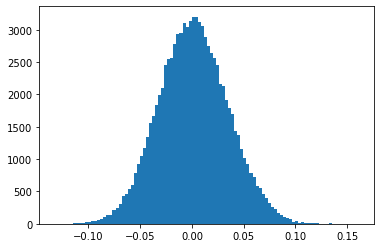

In [252]:
plt.hist((prob_matrix_f2(l1[:-1], l1[-1:], t_matrix_func1)-T).flatten(), bins=100)
plt.show()

In [255]:
np.median(np.abs(prob_matrix_f2(l1[:-1], l1[-1:], t_matrix_func1)-T))

0.022635077379967006

In [251]:
prob_matrix_f2(l1[:-1], l1[-1:], t_matrix_func1)-T

array([[-0.0104184 ,  0.01914837,  0.02596448, ...,  0.02495673,
         0.01781817, -0.00939935],
       [ 0.01914837, -0.02754052, -0.03772166, ..., -0.03369099,
        -0.02302823,  0.01762623],
       [ 0.02596448, -0.03772166, -0.04759005, ..., -0.02525169,
        -0.01491648,  0.0244891 ],
       ...,
       [ 0.02495673, -0.03369099, -0.02525169, ...,  0.06875604,
         0.05991752,  0.02621845],
       [ 0.01781817, -0.02302823, -0.01491648, ...,  0.05991752,
         0.05142205,  0.01903093],
       [-0.00939935,  0.01762623,  0.0244891 , ...,  0.02621845,
         0.01903093, -0.00837331]])

In [245]:
T

array([[0.6, 0.2, 0.2, ..., 0.6, 0.6, 0.6],
       [0.2, 0.8, 0.8, ..., 0.2, 0.2, 0.2],
       [0.2, 0.8, 0.8, ..., 0.2, 0.2, 0.2],
       ...,
       [0.6, 0.2, 0.2, ..., 0.6, 0.6, 0.6],
       [0.6, 0.2, 0.2, ..., 0.6, 0.6, 0.6],
       [0.6, 0.2, 0.2, ..., 0.6, 0.6, 0.6]])

In [262]:
true_labels = np.random.randint(3,size=300)

n = 300
G = create_graph(n, true_labels, basic_func3)
T = create_transition_matrix(true_labels, basic_func3)

In [268]:
T

array([[0.8, 0.3, 0.8, ..., 0.8, 0.3, 0.3],
       [0.3, 0.9, 0.3, ..., 0.3, 0.3, 0.9],
       [0.8, 0.3, 0.8, ..., 0.8, 0.3, 0.3],
       ...,
       [0.8, 0.3, 0.8, ..., 0.8, 0.3, 0.3],
       [0.3, 0.3, 0.3, ..., 0.3, 0.7, 0.3],
       [0.3, 0.9, 0.3, ..., 0.3, 0.3, 0.9]])

In [270]:
l1 = find_opt_params_f2(G, t_matrix_func1)

         Current function value: 0.614445
         Iterations: 100
         Function evaluations: 31408
         Gradient evaluations: 104


In [271]:
prob_matrix_f2(l1[:-1], l1[-1:], t_matrix_func1)

array([[0.6188917 , 0.21810504, 0.61878393, ..., 0.57622685, 0.54391315,
        0.21651536],
       [0.21810504, 0.93931644, 0.21829898, ..., 0.29487998, 0.35302815,
        0.94217705],
       [0.61878393, 0.21829898, 0.61867624, ..., 0.5761512 , 0.54386182,
        0.21671049],
       ...,
       [0.57622685, 0.29487998, 0.5761512 , ..., 0.5462767 , 0.52359292,
        0.29376405],
       [0.54391315, 0.35302815, 0.54386182, ..., 0.52359292, 0.50820268,
        0.35227103],
       [0.21651536, 0.94217705, 0.21671049, ..., 0.29376405, 0.35227103,
        0.94505532]])

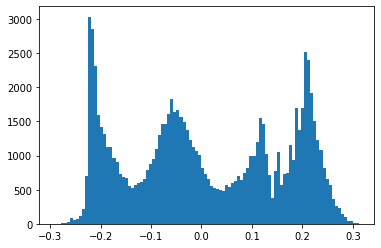

In [272]:
plt.hist((prob_matrix_f2(l1[:-1], l1[-1:], t_matrix_func1)-T).flatten(), bins=100)
plt.show()

In [276]:
def log_likelihood_f2(G, G_c, labels, params, transition_func):
    n = len(labels)
    vec = np.zeros(n).reshape(-1, 1)
    labels = np.array(labels).reshape(-1,1)
    transition_predictions = transition_func(labels, params)
    transition_predictions = np.clip(transition_predictions, .0001, .999)
    prod = transition_predictions*G + (1-transition_predictions)*G_c
    log_matrix = np.log(prod + np.identity(n))
    return np.sum(log_matrix)/(n*(n-1))

def find_opt_params_f2(g, transition_func, num_params=1):
    labels = len(g.nodes)
    G_c = nx.to_numpy_array(nx.complement(g))
    G = nx.to_numpy_array(g)
    func = lambda x: -log_likelihood_f2(G,G_c, x[:-num_params], x[-num_params:], transition_func)
    bounds = [(0,1) for i in range(labels)] + [(None, None) for i in range(num_params)]
    res = minimize(func, list(np.random.rand(labels + num_params)),
                    method='BFGS', options={'maxiter': 100, 'disp': True})
    return res.x

In [277]:
def t_matrix_func3(labels, params=params):
    return params[0] + params[1]*labels @ labels.T + params[2] * labels @ labels.T**2 + params[3] * labels @ labels.T**3

In [279]:
l1 = find_opt_params_f2(G, t_matrix_func3,num_params=4 )

         Current function value: 0.645901
         Iterations: 100
         Function evaluations: 37515
         Gradient evaluations: 123


In [280]:
prob_matrix_f2(l1[:-4], l1[-4:], t_matrix_func3)

array([[0.55097829, 0.60085258, 0.56982898, ..., 0.56350674, 0.39096713,
        0.54491096],
       [0.60893504, 0.69026318, 0.63967416, ..., 0.62936471, 0.34801083,
        0.59904127],
       [0.57157945, 0.63263425, 0.59465597, ..., 0.58691645, 0.37569799,
        0.56415198],
       ...,
       [0.56453968, 0.62177391, 0.58617216, ..., 0.57891695, 0.38091572,
        0.55757699],
       [0.38988032, 0.35232474, 0.37568566, ..., 0.38044634, 0.51036949,
        0.39444905],
       [0.54456646, 0.59096096, 0.56210192, ..., 0.55622078, 0.39571944,
        0.53892245]])

In [281]:
l

array([-0.53922604,  0.54298433, -0.5252948 , -0.5786621 ,  0.58458775,
        0.47113588, -0.53138559, -0.47689265, -0.44825243,  0.42988663,
       -0.60748372, -0.62032639,  0.50017899, -0.46659141, -0.57357888,
        0.51375566,  0.59178698, -0.60926466, -0.4714237 ,  0.54817128,
       -0.57002499, -0.64811648,  0.6107947 , -0.62141727,  0.58332663,
       -0.49678738,  0.50879864, -0.55096375,  0.55133579,  0.47190697,
        0.57482278, -0.55880353,  0.63197573,  0.53394439,  0.69603632,
        0.54799656,  0.57331302,  0.57569423,  0.46835461, -0.49692533,
       -0.54775512, -0.50646981,  0.50311814, -0.58347946,  0.5137215 ,
       -0.61254528,  0.53808472,  0.55373819, -0.49881766,  0.62095061,
       -0.52453969, -0.49683074,  0.46954036,  0.52322201,  0.51756457,
        0.65377129, -0.56415552,  0.49198637,  0.60501429, -0.54540418,
        0.54446403, -0.53789605, -0.56941813, -0.52482557, -0.45088054,
        0.51112791,  0.55808213, -0.55190671, -0.63760224,  0.46

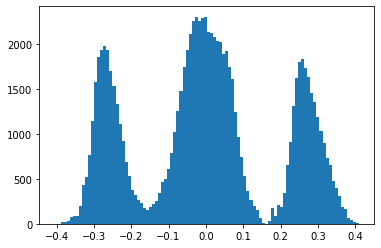

In [283]:
plt.hist((prob_matrix_f2(l1[:-4], l1[-4:], t_matrix_func3)-T).flatten(), bins=100)
plt.show()